## Setup

In [2]:
import random

import tensorflow as tf
import numpy as np

from scraper import Course

[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Parameters

In [2]:
SEED = 1473819
random.seed(SEED)

# training parameters
TRAINING_EPOCHS = 50
BATCH_SIZE = 100
VALIDATION_PROPORTION = 0.2

# model parameters
VOCABULARY_SIZE = 9500
SEQUENCE_LENGTH = 150
EMBEDDING_DIMENSION = 100
DROPOUT_CONSTANT = .2
N_FEATURES = 128
KERNEL_SIZE = 4


## Loading data

In [4]:
with open("courses.jsonl", "rt") as f:
    courses = list(map(Course.from_json, f.readlines()))

DEPARTMENTS = list(set(course.dept for course in courses))
len(DEPARTMENTS)

54

In [18]:
# convert data into tensorflow dataset type
def create_dataset(course_list: list[Course]) -> tf.data.Dataset:
    # preprocessed course descriptions as input
    descriptions = [course.description for course in course_list]

    # one-hot label vectors
    level_labels = tf.keras.utils.to_categorical(
        [int(course.number[0]) - 1 for course in course_list], num_classes=4
    )
    dept_labels = tf.keras.utils.to_categorical(
        [DEPARTMENTS.index(course.dept) for course in course_list],
        num_classes=len(DEPARTMENTS),
    )
    labels = (dept_labels, level_labels)

    # package as batched tensorflow dataset
    return tf.data.Dataset.from_tensor_slices((descriptions, labels)).batch(BATCH_SIZE)

# split course data into training and validation datasets
random.shuffle(courses)
n_train = int(len(courses) * (1 - VALIDATION_PROPORTION))
training_data = create_dataset(courses[:n_train])
validation_data = create_dataset(courses[n_train:])

print(f"Training examples\t\t{n_train}")
print(f"Test examples    \t\t{len(courses) - n_train}")


Training examples		1417
Test examples    		355


## Making the model

### Vectorizing input

We need to convert the preprocessed strings input into into sequences of integers that can be understood by the embedding layer. Each word in the vocabulary gets mapped to a unique integer index.

In [20]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    output_sequence_length=SEQUENCE_LENGTH,
)

# adapt vectorizer to our vocabulary
training_strings_only = training_data.map(lambda x, y: x)
vectorizer.adapt(training_strings_only)

# get the 10 most common words in the vocabulary.
# the first two tokens are reserved for the empty padding
# token (`''`) and the unknown token (`[UNK]`) that is
# given to words not seen during training.

vocabulary = vectorizer.get_vocabulary()
print(vocabulary[:10])


['', '[UNK]', 'course', 'students', 'include', 'class', 'study', 'explore', 'political', 'social']


### Loading pre-trained word embeddings

Creates a 100 dimensional vector for each word to embed the meanings of each word. We experimented with training our own embeddings, but found that department-classification accuracy topped out about 13 percent because we didn't have enough training data to develop understanding about what the words actually meant.

We used [these](https://www.tensorflow.org/text/guide/word_embeddings) [guides](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings) to learn how to implement pre-trained embeddings in tensorflow.


In [6]:
# fetch and unzip embeddings from from stanford research group (~1GB)

# uncomment the following to download:
# !curl -o embeddings/glove.6B.zip "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip" 
# !unzip embeddings/glove.6B.zip -d embeddings

# !rm embeddings/glove.6B.zip
# !rm embeddings/glove.6B.{50d,200d,300d}.txt  # keep only 100-dimensional embeddings

In [7]:
# print out a line of the embedding file

with open("embeddings/glove.6B.100d.txt") as f:
    print(f.readline())

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062



Next, we need to coerce the embeddings into a format understandable by tensorflow.

In [8]:
# create mapping : word -> embedding as string of space-delimited floats
with open("embeddings/glove.6B.100d.txt") as f:
    embeddings = dict(line.split(maxsplit=1) for line in f.readlines())

# create mapping : vocab index -> embedding as numpy vector
embedding_matrix = np.zeros((VOCABULARY_SIZE, EMBEDDING_DIMENSION))
for i, word in enumerate(vocabulary):
    if word not in embeddings:
        # this article suggests to leave the embedding as the 0-vector
        # https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings
        continue

    embedding_matrix[i] = np.fromstring(embeddings[word], dtype=float, sep=" ")

In [9]:
# count number of zero vectors, i.e., tokens in the catalog for which no embeddings exists
no_embedding = np.all(embedding_matrix == 0, axis=1)
print(f"Unable to find embedding for {np.count_nonzero(no_embedding)} out of {VOCABULARY_SIZE} tokens")

# print out the words themselves... they're pretty obscure
no_embedding_indices = np.arange(VOCABULARY_SIZE)[no_embedding]
np.take(vocabulary, no_embedding_indices)[:25]

Unable to find embedding for 223 out of 9500 tokens


array(['', '[UNK]', 'posc', 'latinx', 'handbuilding', 'zhongruan',
       'ireal', 'indigeneity', 'eportfolio', 'dumbek', 'bawu',
       'recontextualization', 'psyc', 'oeconomicus', 'latinxs',
       'improvisationally', 'autofictional', 'accompanimental', 'özdamar',
       'uality', 'transnationally', 'tawada', 'maroonage', 'fieldtrips',
       'familiarizes'], dtype='<U20')

In [10]:
# package matrix as keras layer

pretrained_embedding_layer = tf.keras.layers.Embedding(
    VOCABULARY_SIZE,
    EMBEDDING_DIMENSION,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # type: ignore
    trainable=True,  # don't update the weights as we train
    # TODO try this with trainable = True?
)

### Assembling the model

Inspiration for architecture taken from 

- https://www.atmosera.com/blog/text-classification-with-neural-networks/ (tokenizing input during preprocessing)
- https://www.tensorflow.org/tutorials/keras/text_classification (vectorizing input)
- https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings (pretrained embeddings)
- https://cezannec.github.io/CNN_Text_Classification/ (using 1-d convolution)


In [15]:
input = tf.keras.Input(shape=(), dtype="string")

x = vectorizer(input)
x = pretrained_embedding_layer(x)

# shared feature-extraction layers
x = tf.keras.layers.Dropout(DROPOUT_CONSTANT)(x)
x = tf.keras.layers.Conv1D(N_FEATURES, KERNEL_SIZE, activation="relu", name = "features")(x)
x = tf.keras.layers.Dropout(DROPOUT_CONSTANT)(x)
x = tf.keras.layers.GlobalMaxPool1D(name = "features-pooled")(x)

# two separate output layers
y_dept = tf.keras.layers.Dense(len(DEPARTMENTS), activation="softmax", name = "dept")(x)
y_level = tf.keras.layers.Dense(4, activation="softmax", name = "level")(x)

model = tf.keras.Model(inputs = input, outputs = (y_dept, y_level))

## Training

In [16]:
model.compile(
    loss=tf.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
)

training_history = model.fit(
    training_data,
    epochs=TRAINING_EPOCHS,
    validation_data=validation_data,
    verbose=0,
)


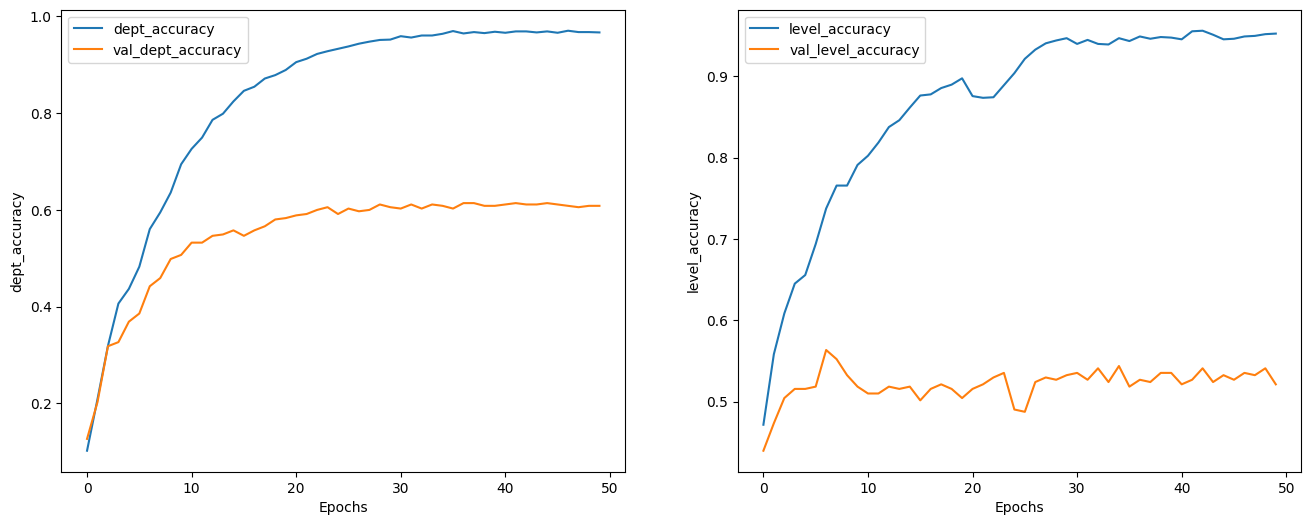

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(training_history, 'dept_accuracy')
plt.subplot(1, 2, 2)
plot_graphs(training_history, 'level_accuracy')

## Polishing for deployment

In [21]:
# create final output layer for model that returns
# (a) a tensor of departments, sorted from most to least probable
# (b) the associated tensor of department probabilities
# (c) a tensor of course level probabilities

@tf.keras.utils.register_keras_serializable()
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, department_names: list[str], **kwargs):
        super().__init__(**kwargs)
        self.department_names = department_names

    def call(self, unsorted_probabilities):
        """Returns a tensor of departments ranked most to least 
        likely and a tensor of the corresponding probabilities."""
        
        sorted_indices = tf.argsort(unsorted_probabilities, axis=-1, direction="DESCENDING")
        sorted_departments = tf.gather(self.department_names, sorted_indices)
        sorted_probabilities = tf.sort(unsorted_probabilities, axis=-1, direction="DESCENDING")
        
        return sorted_departments, sorted_probabilities

    def get_config(self):
        """Method used to serialize and deserialize the layer."""
        return super().get_config() | {"department_names": self.department_names}


dept_probabilities, level_probabilities = model.output
dept_names, dept_probabilities = OutputLayer(DEPARTMENTS)(dept_probabilities)  # type: ignore

complete_model = tf.keras.Model(
    inputs=model.input,
    outputs=[dept_names, dept_probabilities, level_probabilities],
)

In [23]:
complete_model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
